In [1]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense,Concatenate, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal

import math
import matplotlib.pyplot as plt

import pypianoroll
import numpy as np
from pypianoroll import Multitrack, Track

In [2]:
# run params
run_id = '3001'
music_name = 'gan/'

RUN_FOLDER = 'run/'
RUN_FOLDER += '_'.join([run_id, music_name])
IMAGE_FOLDER = os.path.join(RUN_FOLDER, "test_split/")
BASS_IMAGE_FOLDER = os.path.join(IMAGE_FOLDER, "bass/")
MELODY_IMAGE_FOLDER = os.path.join(IMAGE_FOLDER, "melody/")
# Number of timestept the slices Pianorolls should have (Needs to be dividable by 16)
pianrollLength = 256

store_folder = os.path.join(RUN_FOLDER, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'store'))
    os.mkdir(os.path.join(RUN_FOLDER, 'output'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))

if not os.path.exists(IMAGE_FOLDER):
    os.mkdir(IMAGE_FOLDER)
    os.mkdir(BASS_IMAGE_FOLDER)
    os.mkdir(MELODY_IMAGE_FOLDER)

#weight_init = RandomNormal(mean=0., stddev=0.02)
weight_init = tf.keras.initializers.GlorotUniform(seed=None)
#weight_init = tf.keras.initializers.he_uniform(seed=None)

In [3]:
# Set Note bounds for faster training
lowestNotePossible = 20
highestNotePossible = 108
# possibleNotes mus be dividable by 4 else the Architekture needs to be changed
possibleNotes = highestNotePossible - lowestNotePossible
# Bass Line
bassNotes = 40
melodyNotes = possibleNotes - bassNotes

In [4]:
# Save the numpyArray for further us
'''
reshaped = np.load('data/preprocessed/midi_p128_dn88.npy')
isNormalized = False

reshaped = np.load('data/preprocessed/midi_normalized_p128_dn88.npy')
isNormalized = True
'''

reshaped = np.load('data/preprocessed/midi_binarized_p128_dn88.npy')
isNormalized = True

(217, 256, 88, 1)


In [5]:
bass = reshaped[:,:,0:bassNotes]
melody = reshaped[:,:,bassNotes:possibleNotes]

print(melody.shape)
print(bass.shape)

reshaped = []

(217, 256, 48, 1)
(217, 256, 40, 1)


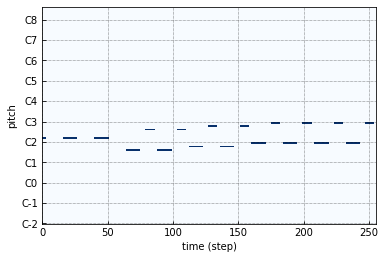

In [6]:
reshaped = bass.reshape(-1, pianrollLength, bassNotes)
result = np.zeros((pianrollLength, 128))
result[:,lowestNotePossible:highestNotePossible-melodyNotes] = reshaped[25]
result.shape
# Test convert an image back to see the Splitted Arrays Plotted
track = Track(pianoroll=result, program=0, is_drum=False,name='my awesome piano')
track.plot()
#plt.savefig(os.path.join(RUN_FOLDER, "example_pianoroll.png"), format='png')
plt.show()
plt.close()

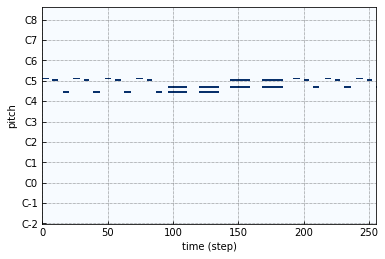

In [8]:
reshaped = melody.reshape(-1, pianrollLength, melodyNotes)
result = np.zeros((pianrollLength, 128))
result[:,lowestNotePossible+bassNotes:highestNotePossible] = reshaped[35]
result.shape
# Test convert an image back to see the Splitted Arrays Plotted
track = Track(pianoroll=result, program=0, is_drum=False,name='my awesome piano')
track.plot()
#plt.savefig(os.path.join(RUN_FOLDER, "example_pianoroll.png"), format='png')
plt.show()
plt.close()

# Creating the neural Network

### Melody Network

In [8]:
### THE Melody discriminator
discriminator_melody_input = Input(shape=(pianrollLength,melodyNotes,1), name='discriminator_melody_input')

x = discriminator_melody_input


x = Conv2D(filters = 64, kernel_size = (5,5), strides=2, kernel_initializer = weight_init, name = 'discriminator_melody_conv_0')(x)
x = LeakyReLU()(x)
#x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Conv2D(filters = 32, kernel_size = (5,5), strides=2, kernel_initializer = weight_init, name = 'discriminator_melody_conv_1')(x)
x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Conv2D(filters = 16, kernel_size = (1,5), strides=2, kernel_initializer = weight_init, name = 'discriminator_melody_conv_middle')(x)
x = LeakyReLU()(x)

x = Flatten()(x)

discriminator_melody_output = Dense(1, activation='sigmoid', kernel_initializer = weight_init)(x)
discriminator_melody = Model(discriminator_melody_input, discriminator_melody_output, name= 'discriminator_melody')

In [9]:
discriminator_melody.summary()

Model: "discriminator_melody"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_melody_input ( [(None, 128, 48, 1)]      0         
_________________________________________________________________
discriminator_melody_conv_0  (None, 62, 22, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 22, 32)        0         
_________________________________________________________________
discriminator_melody_conv_mi (None, 31, 9, 16)         2576      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 31, 9, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4464)     

In [10]:
z_dim = 50

generator_melody_input = Input(shape=(z_dim,), name='generator_melody_input')
generator_melody_initial_dense_layer_size = (int(pianrollLength/4),int(melodyNotes/4),4)

x = generator_melody_input
x = Dense(np.prod(generator_melody_initial_dense_layer_size), kernel_initializer = weight_init)(x)
#x = BatchNormalization(momentum=0.9)(x)

#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Reshape(generator_melody_initial_dense_layer_size)(x)

#x = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
#x = Conv2D(filters = 16, kernel_size = (5,5), padding='same', kernel_initializer = weight_init, name = 'generator_melody_conv_0')(x)
x = Conv2DTranspose(
                    filters = 16
                    , kernel_size = (5,5)
                    , padding = 'same'
                    , strides = 2
                    , name = 'generator_tconv_0'
                    , kernel_initializer = weight_init
                    )(x)
#x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)  
x = Dropout(0.2)(x)

#x = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
#x = Conv2D(filters = 16, kernel_size = (5,5), padding='same', kernel_initializer = weight_init, name = 'generator_melody_conv_1')(x)
x = Conv2DTranspose(
                    filters = 32
                    , kernel_size = (7,7)
                    , padding = 'same'
                    , strides = 2
                    , name = 'generator_tconv_1'
                    , kernel_initializer = weight_init
                    )(x)
#x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Conv2D(filters = 16, kernel_size = (5,5), padding = 'same', kernel_initializer = weight_init, name = 'generator_melody_conv_2')(x)
#x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)

x = Conv2D(filters = 1, kernel_size = (5,5), padding = 'same', kernel_initializer = weight_init)(x)        
x = Activation('sigmoid')(x)


generator_melody_output = x
generator_melody = Model(generator_melody_input, generator_melody_output, name='generator_melody')

In [11]:
generator_melody.summary()

Model: "generator_melody"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_melody_input (Inpu [(None, 50)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1536)              78336     
_________________________________________________________________
activation (Activation)      (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 12, 4)         0         
_________________________________________________________________
generator_tconv_0 (Conv2DTra (None, 64, 24, 16)        1616      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 24, 16)   

### Meldy Network

In [12]:
### THE Melody discriminator
discriminator_bass_input = Input(shape=(pianrollLength,bassNotes,1), name='discriminator_bass_input')

x = discriminator_bass_input


x = Conv2D(filters = 16, kernel_size = (6,6), strides=2, kernel_initializer = weight_init, name = 'discriminator_bass_conv_0')(x)
x = LeakyReLU()(x)
#x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters = 16, kernel_size = (1,6), strides=2, kernel_initializer = weight_init, name = 'discriminator_bass_conv_middle')(x)
x = LeakyReLU()(x)

x = Flatten()(x)

discriminator_bass_output = Dense(1, activation='sigmoid', kernel_initializer = weight_init)(x)
discriminator_bass = Model(discriminator_bass_input, discriminator_bass_output, name= 'discriminator_bass')

In [13]:
discriminator_bass.summary()

Model: "discriminator_bass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_bass_input (In [(None, 128, 40, 1)]      0         
_________________________________________________________________
discriminator_bass_conv_0 (C (None, 62, 18, 16)        592       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 62, 18, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 18, 16)        0         
_________________________________________________________________
discriminator_bass_conv_midd (None, 31, 7, 16)         1552      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 31, 7, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3472)       

In [14]:
z_dim = 50

generator_bass_input = Input(shape=(z_dim,), name='generator_bass_input')
generator_bass_initial_dense_layer_size = (int(pianrollLength/4),int(bassNotes/4),4)

x = generator_bass_input
x = Dense(np.prod(generator_bass_initial_dense_layer_size), kernel_initializer = weight_init)(x)
#x = BatchNormalization(momentum=0.9)(x)

#x = LeakyReLU()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Reshape(generator_bass_initial_dense_layer_size)(x)

x = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
x = Conv2D(filters = 32, kernel_size = (5,5), padding='same', kernel_initializer = weight_init, name = 'generator_bass_conv_0')(x)
#x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)  

x = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
x = Conv2D(filters = 32, kernel_size = (5,5), padding='same', kernel_initializer = weight_init, name = 'generator_bass_conv_1')(x)
#x = Conv2DTranspose(
#                    filters = (5,5)
#                    , kernel_size = 2
#                    , padding = 'same'
#                    , strides = 2
#                    , name = 'generator_tconv_0'
#                    , kernel_initializer = weight_init
#                    )(x)
#x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x) 

x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', kernel_initializer = weight_init, name = 'generator_bass_conv_2')(x)
#x = BatchNormalization(momentum=0.9)(x)
#x = LeakyReLU()(x)
x = Activation('relu')(x)

x = Conv2D(filters = 1, kernel_size = (5,5), padding = 'same', kernel_initializer = weight_init)(x)        
x = Activation('sigmoid')(x)


generator_bass_output = x
generator_bass = Model(generator_bass_input, generator_bass_output, name='generator_bass')

In [15]:
generator_bass.summary()

Model: "generator_bass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_bass_input (InputL [(None, 50)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1280)              65280     
_________________________________________________________________
activation_5 (Activation)    (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 10, 4)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 20, 4)         0         
_________________________________________________________________
generator_bass_conv_0 (Conv2 (None, 64, 20, 32)     

In [16]:
# Quelle: https://stackoverflow.com/a/45199301
# Save the summary to a file 
#from contextlib import redirect_stdout

#with open(os.path.join(store_folder, 'modelsummarydiscriminator.txt'), 'w') as f:
#    with redirect_stdout(f):
#        discriminator.summary()

In [17]:
# Quelle: https://stackoverflow.com/a/45199301
# Save the summary to a file 
#from contextlib import redirect_stdout

#with open(os.path.join(store_folder, 'modelsummarygenerator.txt'), 'w') as f:
#    with redirect_stdout(f):
#        generator.summary()

In [18]:
def set_trainable(model, isTrainable):
    for layer in model.layers:
        layer.trainable = isTrainable

### Compile Melody GAN

In [19]:
### COMPILE DISCRIMINATOR
discriminator_melody.compile(
optimizer=RMSprop(lr=0.0004)
, loss = 'binary_crossentropy'
,  metrics = ['accuracy']
)
        
### COMPILE THE FULL GAN
set_trainable(discriminator_melody, False)

model_input = Input(shape=(z_dim,), name='model_melody_input')
model_output = discriminator_melody(generator_melody(model_input))
GANModel_melody = Model(model_input, model_output)

opti = RMSprop(learning_rate=0.0001)
GANModel_melody.compile(optimizer=opti , loss='binary_crossentropy', metrics=['accuracy'])

set_trainable(discriminator_melody, True)


In [20]:
#plot_model(model_melody, to_file=os.path.join(RUN_FOLDER ,'viz/model_melody.png'), show_shapes = True, show_layer_names = True)
#plot_model(discriminator_melody, to_file=os.path.join(RUN_FOLDER ,'viz/discriminator_melody.png'), show_shapes = True, show_layer_names = True)
#plot_model(generator_melody, to_file=os.path.join(RUN_FOLDER ,'viz/generator_melody.png'), show_shapes = True, show_layer_names = True)

### Compile Bass GAN

In [21]:
'''
### COMPILE DISCRIMINATOR
discriminator_bass.compile(
optimizer=RMSprop(lr=0.0004)
, loss = 'binary_crossentropy'
,  metrics = ['accuracy']
)
        
### COMPILE THE FULL GAN
set_trainable(discriminator_bass, False)

model_input = Input(shape=(z_dim,), name='model_bass_input')
model_output = discriminator_bass(generator_bass(model_input))
GANModel_bass = Model(model_input, model_output)

opti = RMSprop(learning_rate=0.0001)
GANModel_bass.compile(optimizer=opti , loss='binary_crossentropy', metrics=['accuracy'])

set_trainable(discriminator_bass, True)
'''

"\n### COMPILE DISCRIMINATOR\ndiscriminator_bass.compile(\noptimizer=RMSprop(lr=0.0004)\n, loss = 'binary_crossentropy'\n,  metrics = ['accuracy']\n)\n        \n### COMPILE THE FULL GAN\nset_trainable(discriminator_bass, False)\n\nmodel_input = Input(shape=(z_dim,), name='model_bass_input')\nmodel_output = discriminator_bass(generator_bass(model_input))\nGANModel_bass = Model(model_input, model_output)\n\nopti = RMSprop(learning_rate=0.0001)\nGANModel_bass.compile(optimizer=opti , loss='binary_crossentropy', metrics=['accuracy'])\n\nset_trainable(discriminator_bass, True)\n"

In [22]:
#plot_model(model, to_file=os.path.join(RUN_FOLDER ,'viz/model.png'), show_shapes = True, show_layer_names = True)
#plot_model(discriminator, to_file=os.path.join(RUN_FOLDER ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
#plot_model(generator, to_file=os.path.join(RUN_FOLDER ,'viz/generator.png'), show_shapes = True, show_layer_names = True)

# Training of the GAN

In [23]:
def generate_Midi_File(img, epoch, isNormalized, isMelody):
    if isMelody:
        gen_img = img.reshape(128, melodyNotes)
    else:
        gen_img = img.reshape(128, bassNotes)
    result = np.zeros((pianrollLength, 128))
    if isMelody:
        result[:,lowestNotePossible+bassNotes:highestNotePossible] = gen_img
    else:
        result[:,lowestNotePossible:highestNotePossible-melodyNotes] = gen_img    
    #if isNormalized:
    #result = (result > 0.1) * 255.
    result = result * 255.
    
    track = Track(pianoroll=result, program=0, is_drum=False,name='my awesome piano')

    multi = Multitrack()
    multi.tracks[0] = track
    pypianoroll.write(multi, os.path.join(IMAGE_FOLDER, str(epoch)+".mid"))
    
    multi.tracks[0].plot()
    #fig.set_size_inches(100,100)
    #plt.show()
    plt.savefig(os.path.join(IMAGE_FOLDER, str(epoch)+"_pianoroll.png"), format='png')
    plt.close()

In [24]:
def sample_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, z_dim))
        gen_imgs = generator.predict(noise)

        #Rescale images 0 - 1

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(IMAGE_FOLDER, "%d_multi.png" % epoch))
        plt.close()

In [25]:
def train_normal(epochs, batch_size=32, isMelody=True):
    # Save the Generator and discriminator models
    #save_model(generator, os.path.join(RUN_FOLDER, 'images/generator'))
    #save_model(discriminator, os.path.join(RUN_FOLDER, 'images/discriminator'))
    #save_model(GANModel, os.path.join(RUN_FOLDER, r"images/GANModel"))
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    # Label Smoothening
    valid_smoothened = np.random.uniform(low=0.8, high=1.0, size=(batch_size,1))
    fake_smoothened = np.random.uniform(low=0.0, high=0.05, size=(batch_size,1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------      
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)
            
        # Select a random half of images
        idx = np.random.randint(0, reshaped.shape[0], batch_size)
        imgs = reshaped[idx]
        
        # ---------------------
        #  Train the discriminator (real classified as ones and generated as zeros)
        # ---------------------
        d_loss_real, d_acc_real =  discriminator.train_on_batch(imgs, valid)
        d_loss_fake, d_acc_fake =  discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = GANModel.train_on_batch(noise, valid)
        #print ("%d [G loss: %.3f] [G acc: %.3f]" % (epoch, g_loss[0], g_loss[1]))
        
        # ---------------------
        #  Save Losses for evaluation
        # ---------------------
        d = [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]
        d_losses.append(d)
        g = [g_loss[0], g_loss[1]]
        g_losses.append(g)
        
        
        if (epoch % 100 == 0): 
            # Save an example
            fig=plt.figure(figsize=(64, 64))
            plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
            plt.axis('off')
            plt.savefig(os.path.join(IMAGE_FOLDER, str(epoch)+".png"), format='png')
            generate_Midi_File(gen_imgs[0, :, :, 0], epoch, isNormalized, isMelody)
            plt.close()
            
            # Save some examples
            sample_images(epoch)
            
            # Continuiously save a plot with the new values to see the development of the loss
            fig = plt.figure()
            plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)
            plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
            plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
            plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

            plt.xlabel('batch', fontsize=18)
            plt.ylabel('loss', fontsize=16)

            # plt.xlim(0, 2000)
            #plt.ylim(0, 50)

            plt.savefig(os.path.join(IMAGE_FOLDER, "loss_chart.png"), format='png')
            plt.show()
            plt.close
            # Save the loss arrays
            np.save(os.path.join(IMAGE_FOLDER, "D_loss.npy"), d_losses)
            np.save(os.path.join(IMAGE_FOLDER, "G_loss.npy"), g_losses)
            
            if (epoch % 1000 == 0):
                GANModel.save(os.path.join(IMAGE_FOLDER, 'GANModel_'+str(epoch)+'_loss_'+str(g_loss[0])+'.h5'))
                discriminator.save(os.path.join(IMAGE_FOLDER, 'discriminator_'+str(epoch)+'_loss_'+str(d_loss)+'.h5'))
                generator.save(os.path.join(IMAGE_FOLDER, 'generator_'+str(epoch)+'_loss_'+str(g_loss[0])+'.h5'))
                
                
        # Plot the progress
        if (epoch % 10 == 0):
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake, g_loss[0], g_loss[1]))

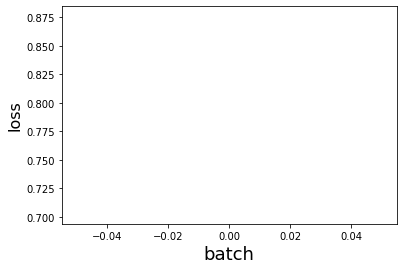

0 [D loss: (0.734)(R 0.703, F 0.764)] [D acc: (0.188)(0.375, 0.000)] [G loss: 0.876] [G acc: 0.000]
10 [D loss: (0.361)(R 0.668, F 0.053)] [D acc: (0.844)(0.688, 1.000)] [G loss: 3.260] [G acc: 0.000]
20 [D loss: (0.183)(R 0.346, F 0.019)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.310] [G acc: 0.000]
30 [D loss: (0.049)(R 0.089, F 0.009)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.106] [G acc: 0.000]
40 [D loss: (0.021)(R 0.035, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.392] [G acc: 0.000]
50 [D loss: (0.007)(R 0.008, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.735] [G acc: 0.000]
60 [D loss: (0.016)(R 0.015, F 0.017)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.488] [G acc: 0.000]
70 [D loss: (0.260)(R 0.118, F 0.401)] [D acc: (0.844)(0.938, 0.750)] [G loss: 2.545] [G acc: 0.062]
80 [D loss: (0.483)(R 0.270, F 0.696)] [D acc: (0.719)(0.938, 0.500)] [G loss: 1.220] [G acc: 0.375]
90 [D loss: (0.717)(R 0.727, F 0.707)] [D acc: (0.688)(0.812, 0.562)] [G loss: 1.003] [G acc

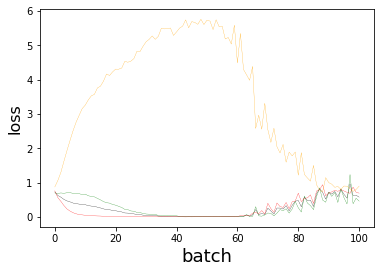

100 [D loss: (0.580)(R 0.463, F 0.696)] [D acc: (0.688)(0.875, 0.500)] [G loss: 0.902] [G acc: 0.188]
110 [D loss: (0.598)(R 0.516, F 0.680)] [D acc: (0.719)(0.875, 0.562)] [G loss: 0.877] [G acc: 0.188]
120 [D loss: (0.507)(R 0.432, F 0.583)] [D acc: (0.875)(0.875, 0.875)] [G loss: 0.959] [G acc: 0.000]
130 [D loss: (0.368)(R 0.287, F 0.450)] [D acc: (0.969)(0.938, 1.000)] [G loss: 1.157] [G acc: 0.000]
140 [D loss: (0.348)(R 0.266, F 0.430)] [D acc: (0.969)(0.938, 1.000)] [G loss: 1.167] [G acc: 0.000]
150 [D loss: (0.304)(R 0.242, F 0.365)] [D acc: (0.969)(0.938, 1.000)] [G loss: 1.316] [G acc: 0.000]
160 [D loss: (0.253)(R 0.216, F 0.290)] [D acc: (0.938)(0.875, 1.000)] [G loss: 1.492] [G acc: 0.000]
170 [D loss: (0.226)(R 0.211, F 0.241)] [D acc: (0.938)(0.875, 1.000)] [G loss: 1.677] [G acc: 0.000]
180 [D loss: (0.170)(R 0.120, F 0.220)] [D acc: (0.969)(0.938, 1.000)] [G loss: 1.742] [G acc: 0.000]
190 [D loss: (0.148)(R 0.144, F 0.153)] [D acc: (0.969)(0.938, 1.000)] [G loss: 2.

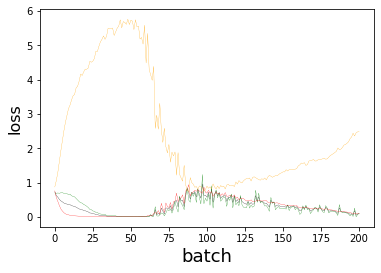

200 [D loss: (0.102)(R 0.102, F 0.101)] [D acc: (0.969)(0.938, 1.000)] [G loss: 2.493] [G acc: 0.000]
210 [D loss: (0.152)(R 0.200, F 0.105)] [D acc: (0.938)(0.875, 1.000)] [G loss: 2.454] [G acc: 0.000]
220 [D loss: (0.118)(R 0.164, F 0.072)] [D acc: (0.938)(0.875, 1.000)] [G loss: 2.816] [G acc: 0.000]
230 [D loss: (0.030)(R 0.002, F 0.057)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.023] [G acc: 0.000]
240 [D loss: (0.080)(R 0.105, F 0.054)] [D acc: (0.969)(0.938, 1.000)] [G loss: 3.076] [G acc: 0.000]
250 [D loss: (0.025)(R 0.007, F 0.043)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.286] [G acc: 0.000]
260 [D loss: (0.018)(R 0.008, F 0.029)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.727] [G acc: 0.000]
270 [D loss: (0.012)(R 0.004, F 0.020)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.108] [G acc: 0.000]
280 [D loss: (0.099)(R 0.174, F 0.024)] [D acc: (0.969)(0.938, 1.000)] [G loss: 3.878] [G acc: 0.000]
290 [D loss: (0.009)(R 0.000, F 0.018)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.

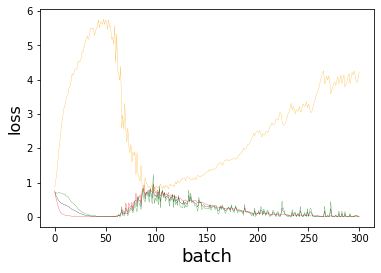

300 [D loss: (0.010)(R 0.000, F 0.020)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.223] [G acc: 0.000]
310 [D loss: (0.022)(R 0.000, F 0.044)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.743] [G acc: 0.000]
320 [D loss: (0.234)(R 0.200, F 0.268)] [D acc: (0.906)(0.938, 0.875)] [G loss: 3.867] [G acc: 0.062]
330 [D loss: (1.059)(R 1.581, F 0.536)] [D acc: (0.750)(0.688, 0.812)] [G loss: 4.175] [G acc: 0.062]
340 [D loss: (0.864)(R 1.490, F 0.238)] [D acc: (0.781)(0.625, 0.938)] [G loss: 7.794] [G acc: 0.000]
350 [D loss: (0.506)(R 0.837, F 0.176)] [D acc: (0.812)(0.750, 0.875)] [G loss: 9.006] [G acc: 0.000]
360 [D loss: (0.145)(R 0.286, F 0.003)] [D acc: (0.938)(0.875, 1.000)] [G loss: 7.953] [G acc: 0.000]
370 [D loss: (0.023)(R 0.044, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.558] [G acc: 0.000]
380 [D loss: (0.019)(R 0.022, F 0.015)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.697] [G acc: 0.000]
390 [D loss: (0.071)(R 0.106, F 0.037)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.

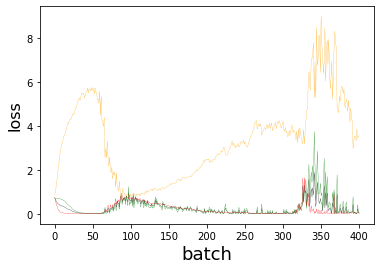

400 [D loss: (0.030)(R 0.013, F 0.047)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.571] [G acc: 0.000]
410 [D loss: (0.100)(R 0.132, F 0.067)] [D acc: (0.969)(0.938, 1.000)] [G loss: 3.101] [G acc: 0.000]
420 [D loss: (0.052)(R 0.055, F 0.049)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.342] [G acc: 0.000]
430 [D loss: (0.017)(R 0.000, F 0.034)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.643] [G acc: 0.000]
440 [D loss: (0.028)(R 0.017, F 0.039)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.523] [G acc: 0.000]
450 [D loss: (0.063)(R 0.084, F 0.041)] [D acc: (0.969)(0.938, 1.000)] [G loss: 3.532] [G acc: 0.000]
460 [D loss: (0.013)(R 0.000, F 0.026)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.944] [G acc: 0.000]
470 [D loss: (0.012)(R 0.000, F 0.023)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.005] [G acc: 0.000]
480 [D loss: (0.014)(R 0.014, F 0.014)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.500] [G acc: 0.000]
490 [D loss: (0.020)(R 0.006, F 0.033)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.

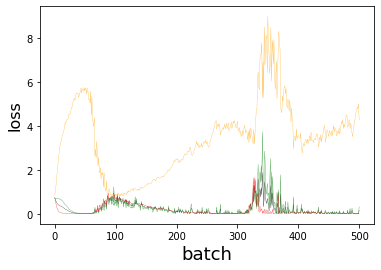

500 [D loss: (0.171)(R 0.324, F 0.018)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.269] [G acc: 0.000]
510 [D loss: (0.008)(R 0.000, F 0.017)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.334] [G acc: 0.000]
520 [D loss: (0.007)(R 0.000, F 0.015)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.439] [G acc: 0.000]
530 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.784] [G acc: 0.000]
540 [D loss: (0.070)(R 0.129, F 0.010)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.806] [G acc: 0.000]
550 [D loss: (0.164)(R 0.313, F 0.016)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.372] [G acc: 0.000]
560 [D loss: (0.174)(R 0.334, F 0.013)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.531] [G acc: 0.000]
570 [D loss: (0.004)(R 0.000, F 0.007)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.141] [G acc: 0.000]
580 [D loss: (0.162)(R 0.305, F 0.019)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.230] [G acc: 0.000]
590 [D loss: (0.005)(R 0.000, F 0.009)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.

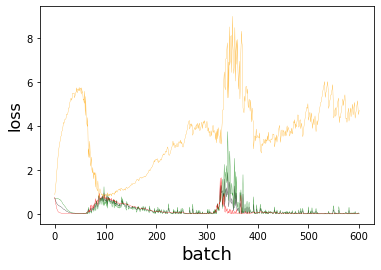

600 [D loss: (0.005)(R 0.000, F 0.011)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.723] [G acc: 0.000]
610 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.609] [G acc: 0.000]
620 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.866] [G acc: 0.000]
630 [D loss: (0.003)(R 0.001, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.369] [G acc: 0.000]
640 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.597] [G acc: 0.000]
650 [D loss: (0.025)(R 0.037, F 0.012)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.638] [G acc: 0.000]
660 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.493] [G acc: 0.000]
670 [D loss: (0.011)(R 0.000, F 0.023)] [D acc: (1.000)(1.000, 1.000)] [G loss: 3.997] [G acc: 0.000]
680 [D loss: (0.005)(R 0.000, F 0.009)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.906] [G acc: 0.000]
690 [D loss: (0.163)(R 0.312, F 0.014)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.

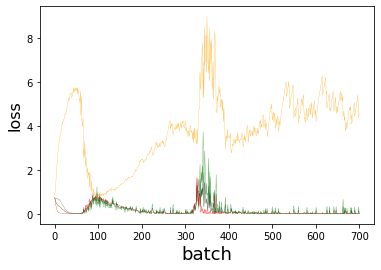

700 [D loss: (0.006)(R 0.000, F 0.013)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.535] [G acc: 0.000]
710 [D loss: (0.004)(R 0.000, F 0.007)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.065] [G acc: 0.000]
720 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.565] [G acc: 0.000]
730 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.614] [G acc: 0.000]
740 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.581] [G acc: 0.000]
750 [D loss: (0.009)(R 0.015, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.938] [G acc: 0.000]
760 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.269] [G acc: 0.000]
770 [D loss: (0.003)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.332] [G acc: 0.000]
780 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.254] [G acc: 0.000]
790 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.

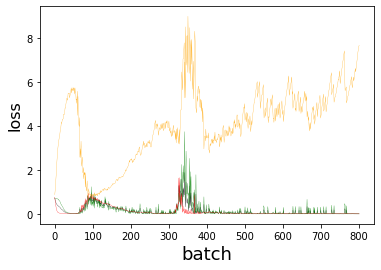

800 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.685] [G acc: 0.000]
810 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.632] [G acc: 0.000]
820 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.238] [G acc: 0.000]
830 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.132] [G acc: 0.000]
840 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.023] [G acc: 0.000]
850 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.483] [G acc: 0.000]
860 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.866] [G acc: 0.000]
870 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.314] [G acc: 0.000]
880 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.046] [G acc: 0.000]
890 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.

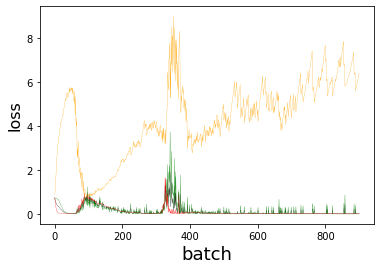

900 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.407] [G acc: 0.000]
910 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.280] [G acc: 0.000]
920 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.357] [G acc: 0.000]
930 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.588] [G acc: 0.000]
940 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.009] [G acc: 0.000]
950 [D loss: (0.183)(R 0.359, F 0.008)] [D acc: (0.969)(0.938, 1.000)] [G loss: 5.009] [G acc: 0.000]
960 [D loss: (0.003)(R 0.000, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.249] [G acc: 0.000]
970 [D loss: (0.005)(R 0.000, F 0.010)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.740] [G acc: 0.000]
980 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.918] [G acc: 0.000]
990 [D loss: (0.003)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.

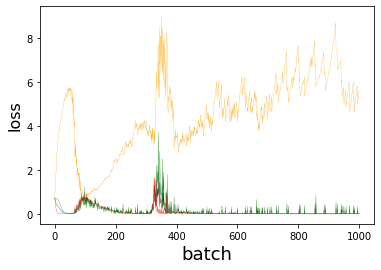

1000 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.587] [G acc: 0.000]
1010 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.666] [G acc: 0.000]
1020 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.747] [G acc: 0.000]
1030 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.882] [G acc: 0.000]
1040 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.999] [G acc: 0.000]
1050 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.913] [G acc: 0.000]
1060 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.108] [G acc: 0.000]
1070 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.848] [G acc: 0.000]
1080 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.634] [G acc: 0.000]
1090 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [

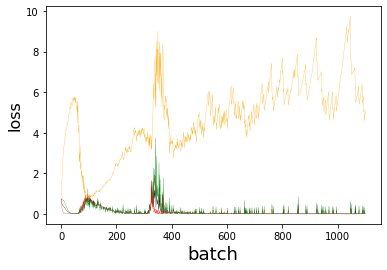

1100 [D loss: (0.004)(R 0.000, F 0.007)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.077] [G acc: 0.000]
1110 [D loss: (0.004)(R 0.000, F 0.007)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.107] [G acc: 0.000]
1120 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.361] [G acc: 0.000]
1130 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.470] [G acc: 0.000]
1140 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.868] [G acc: 0.000]
1150 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.472] [G acc: 0.000]
1160 [D loss: (0.003)(R 0.000, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.213] [G acc: 0.000]
1170 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.140] [G acc: 0.000]
1180 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.147] [G acc: 0.000]
1190 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [

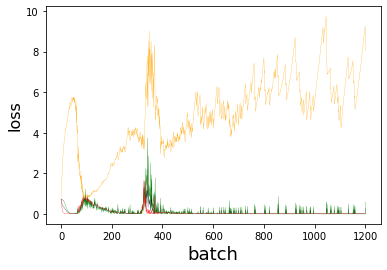

1200 [D loss: (0.292)(R 0.583, F 0.000)] [D acc: (0.969)(0.938, 1.000)] [G loss: 8.055] [G acc: 0.000]
1210 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.721] [G acc: 0.000]
1220 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.284] [G acc: 0.000]
1230 [D loss: (0.218)(R 0.433, F 0.003)] [D acc: (0.969)(0.938, 1.000)] [G loss: 5.953] [G acc: 0.000]
1240 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.867] [G acc: 0.000]
1250 [D loss: (0.004)(R 0.000, F 0.008)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.006] [G acc: 0.000]
1260 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.059] [G acc: 0.000]
1270 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.009] [G acc: 0.000]
1280 [D loss: (0.003)(R 0.000, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.240] [G acc: 0.000]
1290 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [

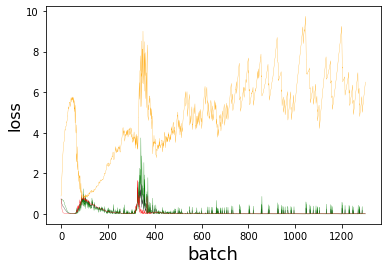

1300 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.499] [G acc: 0.000]
1310 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.257] [G acc: 0.000]
1320 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.016] [G acc: 0.000]
1330 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.911] [G acc: 0.000]
1340 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.575] [G acc: 0.000]
1350 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.695] [G acc: 0.000]
1360 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.589] [G acc: 0.000]
1370 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.589] [G acc: 0.000]
1380 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.440] [G acc: 0.000]
1390 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [

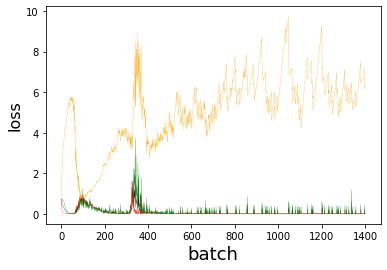

1400 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.386] [G acc: 0.000]
1410 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.050] [G acc: 0.000]
1420 [D loss: (0.208)(R 0.414, F 0.003)] [D acc: (0.969)(0.938, 1.000)] [G loss: 5.846] [G acc: 0.000]
1430 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.782] [G acc: 0.000]
1440 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.727] [G acc: 0.000]
1450 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.793] [G acc: 0.000]
1460 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.158] [G acc: 0.000]
1470 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.576] [G acc: 0.000]
1480 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.874] [G acc: 0.000]
1490 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [

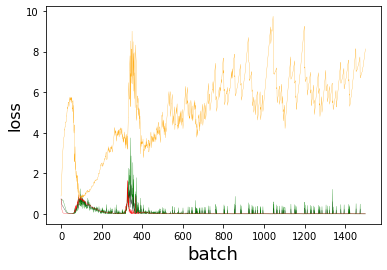

1500 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.135] [G acc: 0.000]
1510 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 9.144] [G acc: 0.000]
1520 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 10.202] [G acc: 0.000]
1530 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.718] [G acc: 0.000]
1540 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.756] [G acc: 0.000]
1550 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.023] [G acc: 0.000]
1560 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.444] [G acc: 0.000]
1570 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.065] [G acc: 0.000]
1580 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.646] [G acc: 0.000]
1590 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] 

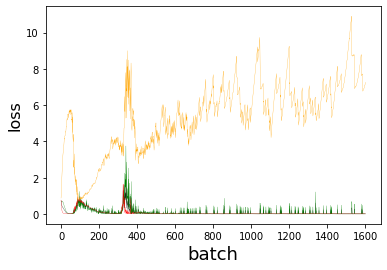

1600 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.262] [G acc: 0.000]
1610 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.962] [G acc: 0.000]
1620 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.401] [G acc: 0.000]
1630 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.405] [G acc: 0.000]
1640 [D loss: (0.003)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.301] [G acc: 0.000]
1650 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.275] [G acc: 0.000]
1660 [D loss: (0.003)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.295] [G acc: 0.000]
1670 [D loss: (0.004)(R 0.000, F 0.008)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.026] [G acc: 0.000]
1680 [D loss: (0.190)(R 0.375, F 0.006)] [D acc: (0.969)(0.938, 1.000)] [G loss: 5.265] [G acc: 0.000]
1690 [D loss: (0.003)(R 0.000, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [

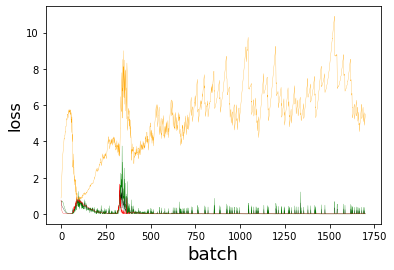

1700 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.515] [G acc: 0.000]
1710 [D loss: (0.145)(R 0.270, F 0.020)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.119] [G acc: 0.000]
1720 [D loss: (0.005)(R 0.000, F 0.010)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.733] [G acc: 0.000]
1730 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.947] [G acc: 0.000]
1740 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.958] [G acc: 0.000]
1750 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.872] [G acc: 0.000]
1760 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.535] [G acc: 0.000]
1770 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.464] [G acc: 0.000]
1780 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.921] [G acc: 0.000]
1790 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [

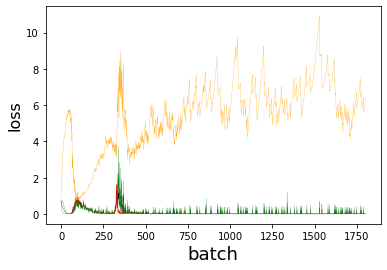

1800 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.423] [G acc: 0.000]
1810 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.394] [G acc: 0.000]
1820 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.671] [G acc: 0.000]
1830 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.567] [G acc: 0.000]
1840 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.456] [G acc: 0.000]
1850 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.534] [G acc: 0.000]
1860 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.499] [G acc: 0.000]
1870 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.398] [G acc: 0.000]
1880 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.506] [G acc: 0.000]
1890 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [

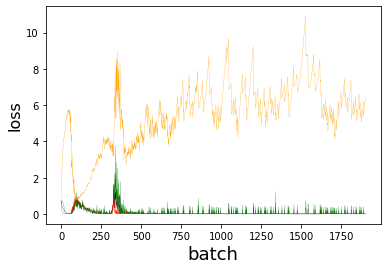

1900 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.444] [G acc: 0.000]
1910 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.175] [G acc: 0.000]
1920 [D loss: (0.170)(R 0.329, F 0.010)] [D acc: (0.969)(0.938, 1.000)] [G loss: 4.735] [G acc: 0.000]
1930 [D loss: (0.003)(R 0.000, F 0.007)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.142] [G acc: 0.000]
1940 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.271] [G acc: 0.000]
1950 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.435] [G acc: 0.000]
1960 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.608] [G acc: 0.000]
1970 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 9.732] [G acc: 0.000]
1980 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 10.915] [G acc: 0.000]
1990 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] 

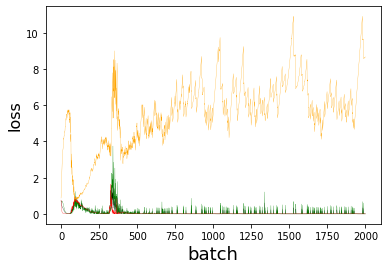

2000 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.671] [G acc: 0.000]
2010 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.877] [G acc: 0.000]
2020 [D loss: (0.289)(R 0.577, F 0.000)] [D acc: (0.969)(0.938, 1.000)] [G loss: 8.017] [G acc: 0.000]
2030 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.327] [G acc: 0.000]
2040 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.622] [G acc: 0.000]
2050 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.273] [G acc: 0.000]
2060 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.823] [G acc: 0.000]
2070 [D loss: (0.202)(R 0.399, F 0.004)] [D acc: (0.969)(0.938, 1.000)] [G loss: 5.578] [G acc: 0.000]
2080 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.491] [G acc: 0.000]
2090 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [

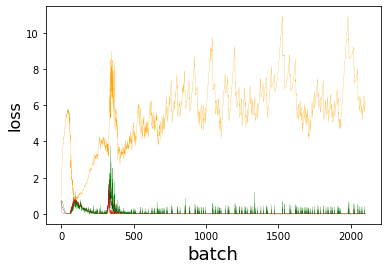

2100 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.229] [G acc: 0.000]
2110 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.146] [G acc: 0.000]
2120 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.080] [G acc: 0.000]
2130 [D loss: (0.003)(R 0.000, F 0.006)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.249] [G acc: 0.000]
2140 [D loss: (0.003)(R 0.000, F 0.007)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.164] [G acc: 0.000]
2150 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.300] [G acc: 0.000]
2160 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.464] [G acc: 0.000]
2170 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.628] [G acc: 0.000]
2180 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.829] [G acc: 0.000]
2190 [D loss: (0.222)(R 0.441, F 0.002)] [D acc: (0.969)(0.938, 1.000)] [

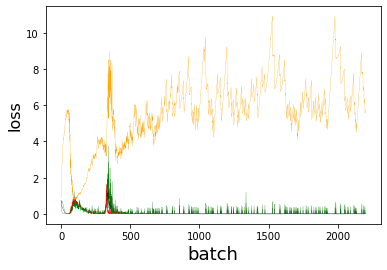

2200 [D loss: (0.002)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.766] [G acc: 0.000]
2210 [D loss: (0.004)(R 0.000, F 0.008)] [D acc: (1.000)(1.000, 1.000)] [G loss: 4.943] [G acc: 0.000]
2220 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.984] [G acc: 0.000]
2230 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.904] [G acc: 0.000]
2240 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.581] [G acc: 0.000]
2250 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.520] [G acc: 0.000]
2260 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.589] [G acc: 0.000]
2270 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.709] [G acc: 0.000]
2280 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.194] [G acc: 0.000]
2290 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [

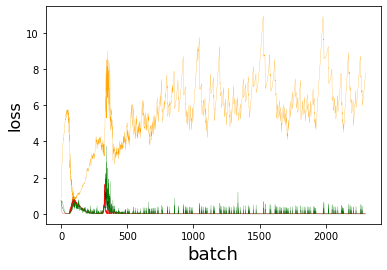

2300 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.779] [G acc: 0.000]
2310 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.061] [G acc: 0.000]
2320 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.529] [G acc: 0.000]
2330 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.322] [G acc: 0.000]
2340 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.553] [G acc: 0.000]
2350 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.737] [G acc: 0.000]
2360 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.275] [G acc: 0.000]
2370 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.902] [G acc: 0.000]
2380 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.592] [G acc: 0.000]
2390 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [

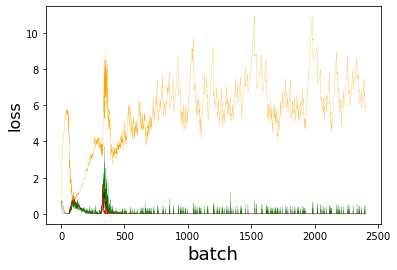

2400 [D loss: (0.001)(R 0.000, F 0.003)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.980] [G acc: 0.000]
2410 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.639] [G acc: 0.000]
2420 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.616] [G acc: 0.000]
2430 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 8.668] [G acc: 0.000]
2440 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.021] [G acc: 0.000]
2450 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.380] [G acc: 0.000]
2460 [D loss: (0.247)(R 0.492, F 0.001)] [D acc: (0.969)(0.938, 1.000)] [G loss: 6.939] [G acc: 0.000]
2470 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.223] [G acc: 0.000]
2480 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.590] [G acc: 0.000]
2490 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [

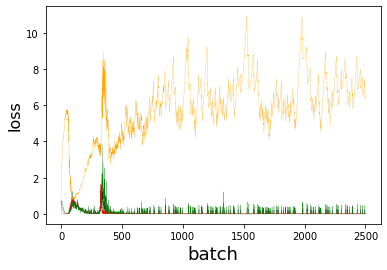

2500 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.532] [G acc: 0.000]
2510 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.069] [G acc: 0.000]
2520 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.882] [G acc: 0.000]
2530 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.133] [G acc: 0.000]
2540 [D loss: (0.000)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.632] [G acc: 0.000]
2550 [D loss: (0.001)(R 0.000, F 0.002)] [D acc: (1.000)(1.000, 1.000)] [G loss: 6.339] [G acc: 0.000]
2560 [D loss: (0.002)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.339] [G acc: 0.000]
2570 [D loss: (0.003)(R 0.000, F 0.005)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.329] [G acc: 0.000]
2580 [D loss: (0.002)(R 0.000, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 5.609] [G acc: 0.000]
2590 [D loss: (0.001)(R 0.000, F 0.001)] [D acc: (1.000)(1.000, 1.000)] [

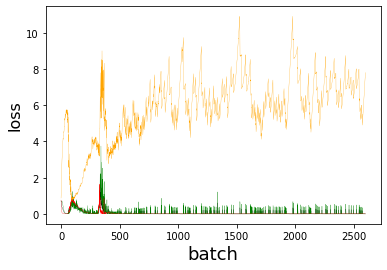

2600 [D loss: (0.000)(R 0.000, F 0.000)] [D acc: (1.000)(1.000, 1.000)] [G loss: 7.804] [G acc: 0.000]


In [ ]:
d_losses = []
g_losses = []

# Variable Initialisations
generator = generator_melody
discriminator = discriminator_melody
GANModel = GANModel_melody
IMAGE_FOLDER = MELODY_IMAGE_FOLDER
reshaped = melody

train_normal(10001, batch_size=16, isMelody=True)

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

#plt.xlim(0, 20000)
plt.ylim(0, 30)

plt.savefig(os.path.join(IMAGE_FOLDER, "loss_chart2.png"), format='png')
plt.show()
plt.close

In [ ]:
# Quelle: https://stackoverflow.com/a/6537563
# Beep to tell training finished
import winsound
frequency = 300  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [ ]:
'''
d_losses = []
g_losses = []

# Variable Initialisations
generator = generator_bass
discriminator = discriminator_bass
GANModel = GANModel_bass
IMAGE_FOLDER = BASS_IMAGE_FOLDER
reshaped = bass

train_normal(10001, batch_size=64, isMelody=False)
'''

In [ ]:
'''
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

#plt.xlim(0, 20000)
plt.ylim(0, 30)

plt.savefig(os.path.join(IMAGE_FOLDER, "loss_chart2.png"), format='png')
plt.show()
plt.close
'''

In [ ]:
# Quelle: https://stackoverflow.com/a/6537563
# Beep to tell training finished
import winsound
frequency = 300  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [ ]:
#d_losses = np.load(os.path.join(IMAGE_FOLDER, "D_loss.npy"))
#g_losses = np.load(os.path.join(IMAGE_FOLDER, "G_loss.npy"))

In [ ]:
#generator = load_model(os.path.join(IMAGE_FOLDER, "First_run/generator_10000_loss_30.628813.h5"))
#discriminator = load_model(os.path.join(IMAGE_FOLDER, "First_run/discriminator_10000_loss_5.734544512425027e-14.h5"))
#GANModel = load_model(os.path.join(IMAGE_FOLDER, "First_run/GANModel_10000_loss_30.628813.h5"))


In [ ]:
#generator.summary()